<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/week03_part2_evaluation_measures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation measures
In this tutorial, we will learn how to use some evaluation measures such as ROC, AUC, R@k and MAP for classification and retrieval problems. Once you finished the tutorial, please do some practices with the **exercises** you can find below.




We will start with the classification problem,  first we import the MNIST dataset:





In [0]:
# importing some modules
import numpy as np
np.random.seed(1337)  # for reproducibility !!!
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from keras.layers.normalization import BatchNormalization

# network parameters
batch_size = 128
n_classes = 10
n_epochs = 12
img_rows, img_cols = 28, 28
n_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)

# import training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# reshape into matrices training and testing data
X_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
X_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)

input_shape = (1, img_rows, img_cols)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print 'X_train size:', X_train.shape 
print 'number of training samples',X_train.shape[0]
print 'number of testing samples',X_test.shape[0]

# convert class vectors to binary class matrices for efficiency reasons
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
      


X_train size: (60000, 1, 28, 28)
number of training samples 60000
number of testing samples 10000


 ... second, we define a small CNN architecture to classifiy digits.



In [0]:
model_cnn = Sequential()

model_cnn.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1]),
                        padding='valid', input_shape=input_shape, data_format = 'channels_first'))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=pool_size))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(n_classes))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 26, 26)        320       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 26, 26)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 13, 26)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 13, 26)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                54090     
_________________________________________________________________
activation_15 (Activation)   (None, 10)                0         
Total para

... third, we train the network for 12 epochs

In [0]:
history =model_cnn.fit(X_train, Y_train, batch_size=batch_size,epochs=n_epochs,
          verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 115us/step - loss: 0.3494 - acc: 0.8990 - val_loss: 0.1604 - val_acc: 0.9568
Epoch 2/12
60000/60000 [==============================] - 4s 72us/step - loss: 0.1359 - acc: 0.9617 - val_loss: 0.0910 - val_acc: 0.9729
Epoch 3/12
60000/60000 [==============================] - 4s 72us/step - loss: 0.1009 - acc: 0.9708 - val_loss: 0.0729 - val_acc: 0.9777
Epoch 4/12
60000/60000 [==============================] - 4s 72us/step - loss: 0.0858 - acc: 0.9748 - val_loss: 0.0644 - val_acc: 0.9798
Epoch 5/12
60000/60000 [==============================] - 4s 71us/step - loss: 0.0764 - acc: 0.9773 - val_loss: 0.0624 - val_acc: 0.9798
Epoch 6/12
60000/60000 [==============================] - 4s 71us/step - loss: 0.0709 - acc: 0.9785 - val_loss: 0.0591 - val_acc: 0.9812
Epoch 7/12
60000/60000 [==============================] - 4s 71us/step - loss: 0.0665 - acc: 0.9802 - val_loss: 0.0544 - val_ac

and finally, we evaluate the model in terms of score and accuracy.

In [0]:
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print 'Test loss:', score[0]
print 'Test accuracy:', score[1]



Test loss: 0.04865028811749071
Test accuracy: 0.9833


# Classification - ROC and AUC

In the previous example, our model has been evaluated with "accuracy" metric, which is the "categorical_accuracy" calculating the mean accuracy rate across all predictions. If you want to evaluate your model with more sophisticated evaluation metrics, you should opt for Receiver Operating Characteristic (ROC) curve or Area Under the Curve (AUC), two widely used metrics illustrating the diagnostic ability of a classifier over different discrimination thresholds. While ROC is an effective tool to visualize performances of a classifier as a graph, AUC summarizes the overall performances in a single number.

Now we are going to define a simple model with only one intermediate layer, named baseline in this tutorial, and compare the performances in term of ROC and AUC with the CNN model we have previuosly defined, showing that the last model is significantly better.

First, we define a model with only one intermediate layer and train it on MNIST.

In [0]:
from keras.utils import to_categorical

x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flat = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

x_train_flat= x_train_flat.astype('float32')
x_test_flat= x_test_flat.astype('float32')

x_train_flat /= 255
x_test_flat /= 255

y_train_c=to_categorical(y_train,n_classes)
y_test_c=to_categorical(y_test,n_classes)

  # Load simple model
model = Sequential()
model.add(Dense(1, activation='relu', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train_flat,y_train_c,batch_size=100, epochs=10,verbose=1,validation_data=(x_test_flat,y_test_c))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 785       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                20        
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 47us/step - loss: 2.0732 - acc: 0.2034 - val_loss: 1.9724 - val_acc: 0.2251
Epoch 2/10
60000/60000 [==============================] - 3s 44us/step - loss: 1.9399 - acc: 0.2349 - val_loss: 1.9005 - val_acc: 0.2462
Epoch 3/10
60000/60000 [==============================] - 3s 44us/step - loss: 1.8776 - acc: 0.2532 - val_loss: 1.8433 - val_acc: 0.2634
Epoch 4/10
60000/60000 [==============================] - 3s 43us/step - loss: 

Next, we evaluate performances of our single layer model with keras evalation method and compare with CNN based model. You can notice the accuracy is considerable lower, i.e. 0.34 compared to CNN based model, i.e. 0.9826

In [0]:
score = model.evaluate(x_test_flat, y_test_c, verbose=1)
print 'Test loss:', score[0]
print 'Accuracy loss:', score[1]

10000/10000 [==============================] - 0s 44us/step
Test loss: 1.706714919090271
Accuracy loss: 0.3346


Now, we will see in more detail how to compute the ROC and AUC for the multicategory classification problem.
The first step to do is predicting the category class for each sample of the testing set.

In [0]:
y_pred_cnn = model_cnn.predict(X_test).ravel()
y_pred = model.predict(x_test_flat).ravel()


ROC and AUC are two metrics for evaluating performances of a binary classifier.  In such a problem, a single ROC curve is enough to fully monitor its quality. 

On the other hand, in case you want to measure the performances of a multicategory classifier, e.g. in MNIST problem, you need multiple ROC curves, whose number strictly depends on the number of classes. 
For example, evaluating a classifier trained on MNIST dataset requires 10 different ROC curves, each one describing the ability to distinguish a particular digit from all the others. This is typically known as 1 versus all setting.


In order to make such metrics working on a multicategory classifier, we need to rearrange a little bit our label and prediction data. 

For this purpose,  we define a function, i.e. set_binary, which takes as input a certain class (query_label) and converts labels and predictions in vectors with the same size: 1) in labels  all the samples belonged to selected class are marked as positive,  while all the others are marked as negative, and 2) in predictions each component contains the confidence values indicating the probability that the corresponding sample is positive (query_label). 

In [0]:
def set_binary(y_pred,y_labels,positive_label):
  bin_y_pred,bin_y_labels=[],[]
  index=0
  for yl in y_labels:
      if yl==positive_label:
        bin_y_labels.append(1)
      else:
        bin_y_labels.append(0)
      
      bin_y_pred.append(y_pred[10*index+positive_label])
      index=index+1

  return [bin_y_pred,bin_y_labels]

After that, we import roc_curve and auc functions from learn.metric module, which are two predefined functions for computing ROC and AUC.
In our example, we assume that the class '5' is the positive class, and compute ROC and AUC value for both the CNN and single layer model. 
You can notice CNN based model works significantly better than our single layer classifier with AUC value 0.99 against only 0.76.


In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
positive_label=5
[bin_y_pred,bin_y_labels]=set_binary(y_pred,y_test,positive_label)
[bin_y_pred_cnn,bin_y_labels_cnn]=set_binary(y_pred_cnn,y_test,positive_label)


fpr_rf, tpr_rf, thresholds_rf = roc_curve(bin_y_labels,bin_y_pred)
fpr_rf_cnn, tpr_rf_cnn, thresholds_rf_cnn = roc_curve(bin_y_labels_cnn,bin_y_pred_cnn)

auc_keras = auc(fpr_rf,tpr_rf)
print(auc_keras)
auc_keras_cnn = auc(fpr_rf_cnn,tpr_rf_cnn)
print(auc_keras_cnn)


0.7569412441829091
0.9998893448030707


We finally plot the roc curves, showing the superiority of cnn based model over the baseline with the green curve always above the blue one.

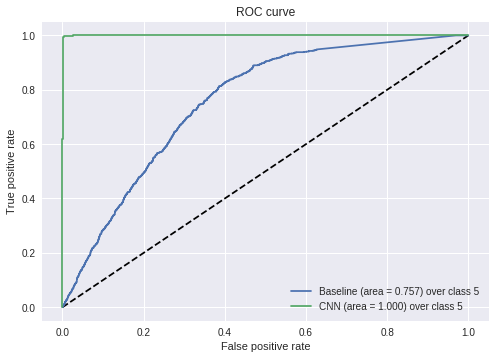

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Baseline (area = {:.3f}) over class 5'.format(auc_keras))
plt.plot(fpr_rf_cnn, tpr_rf_cnn, label='CNN (area = {:.3f}) over class 5'.format(auc_keras_cnn))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()



## Retrieval - R@k and MAP



Let's give a look now at some metrics for retrieval setting, i.e. R@k and MAP.  Such measures are similar to recall and precision we have seen so far in the classification problem with the main difference that during the evaluation a sample is considered as positive if it is ranked higher then a certain threshold, where the threshold is a discrete number. In contrast, in a classification problem, a sample is considered as positive if its confidence value, typically a rational number, is higher then a certain threshold. 

First, we import the MNIST fashion dataset, which is a little bit tougher than MNIST.

In [0]:
from keras.datasets import fashion_mnist
# importing some modules
import numpy as np
np.random.seed(1337)  # for reproducibility !!!
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from keras.layers.normalization import BatchNormalization

# the data, shuffled and split between train and test sets
img_rows, img_cols = 28, 28
n_classes=10
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print 'X_train shape:', X_train.shape
print X_train.shape[0], 'train samples'
print X_test.shape[0], 'test samples'
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

4431872/4422102 [==============================] - 1s 0us/step
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


Second, we visualize some examples to have an idea about how they are. You can see that each grey-scale image contains an article of clothing, e.g. ankle boot, pullover, t-shirt, etc..

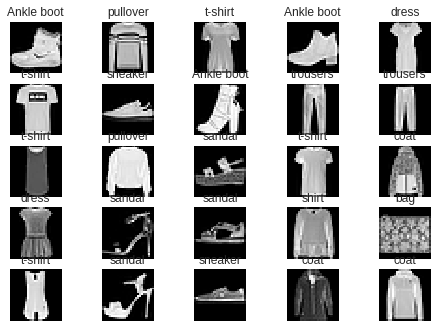

In [0]:
N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
items = ['t-shirt','trousers','pullover','dress','coat','sandal','shirt','sneaker','bag','Ankle boot']
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    axes[row,col].imshow(X_train[idx, 0], cmap='gray')
    y_target = int(y_train[idx])
    target = items[y_target]
    axes[row,col].set_title(target)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Third, we define a simple CNN architecture with few layers and train it on fashion MNIST.

In [0]:
# network parameters
batch_size = 128
n_filters = 64
n_epochs = 12
img_rows, img_cols = 28, 28
pool_size = (2, 2)
kernel_size = (3, 3)

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1]),
                        padding='valid', data_format = 'channels_first'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(n_filters, (kernel_size[0], kernel_size[1])))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 1, 28, 28)         112       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 26, 26)        640       
_________________________________________________________________
activation_7 (Activation)    (None, 64, 26, 26)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 26, 26)        104       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 24, 64)        15040     
_________________________________________________________________
activation_8 (Activation)    (None, 62, 24, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 12, 64)        0         
__________

In [0]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs,
          verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 20s 341us/step - loss: 0.9331 - acc: 0.7212 - val_loss: 0.4045 - val_acc: 0.8608
Epoch 2/12
60000/60000 [==============================] - 19s 318us/step - loss: 0.4670 - acc: 0.8372 - val_loss: 0.3318 - val_acc: 0.8776
Epoch 3/12
60000/60000 [==============================] - 19s 318us/step - loss: 0.3729 - acc: 0.8697 - val_loss: 0.3012 - val_acc: 0.8880
Epoch 4/12
60000/60000 [==============================] - 19s 317us/step - loss: 0.3249 - acc: 0.8836 - val_loss: 0.2837 - val_acc: 0.8983
Epoch 5/12
60000/60000 [==============================] - 19s 316us/step - loss: 0.2912 - acc: 0.8958 - val_loss: 0.2768 - val_acc: 0.9016
Epoch 6/12
60000/60000 [==============================] - 19s 317us/step - loss: 0.2620 - acc: 0.9058 - val_loss: 0.2770 - val_acc: 0.9057
Epoch 7/12
60000/60000 [==============================] - 19s 316us/step - loss: 0.2456 - acc: 0.9098 - val_loss: 0.

Fourth, we extract activations from the last fully connected layer and use them as the feature vectors for the retrieval task, defined as follows: given a query, i.e. a specific article of clothing we want to search for the most similar articles in the gallery and order all the gallery images in ascending order.

In [0]:
from keras import backend as K
extract_feature = K.function([model.layers[0].input],[model.layers[12].output])
gallery_features = extract_feature([X_test[:20,:,:]])
print(len(gallery_features[0]))
gallery_labels=y_test[:20]

probe_features = extract_feature([X_test[20:40,:,:]])
probe_labels=y_test[20:40]


20


The method below computes mean average precision of the model over the probe (test_codes, test_labels) and gallery set (learned_codes, y_train) containing corresponding features and labels. This method is from [sicara blog](https://blog.sicara.com/keras-tutorial-content-based-image-retrieval-convolutional-denoising-autoencoder-dc91450cc511), following the link you can find further documentation about it. 

In [0]:
def compute_mean_average_precision(test_codes, test_labels, learned_codes, y_train, n_samples):
    # For each n_samples (=number of retrieved images to assess) we store the corresponding labels and distances
    out_labels = []
    out_distances = []
    ranks=np.zeros(n_samples)
    
    #For each query image feature we compute the closest images from training dataset
    for i in range(len(test_codes)):
        distances = []
        # Compute the euclidian distance for each feature from training dataset
        for code in learned_codes:
            distance = np.linalg.norm(code - test_codes[i])
            distances.append(distance)
        
        # Store the computed distances and corresponding labels from training dataset
        distances = np.array(distances)
      
        
        # Scoring function needs to replace similar labels by 1 and different ones by 0
        labels = np.copy(y_train).astype('float32')
        labels[labels != test_labels[i]] = -1
        labels[labels == test_labels[i]] = 1
        labels[labels == -1] = 0
        distance_with_labels = np.stack((distances, labels), axis=-1)
        sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]
        
        # The distances are between 0 and 28. The lesser the distance the bigger the relevance score should be
        sorted_distances = 1 - sorted_distance_with_labels[:, 0]
        sorted_labels = sorted_distance_with_labels[:, 1]
        ranks[np.where(sorted_labels==1)]=ranks[ np.where(sorted_labels==1)]+1
        
        # We keep only n_samples closest elements from the images retrieved
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])


    out_labels = np.array(out_labels)
    out_distances = np.array(out_distances)
    ranks=np.cumsum(ranks)/np.sum(ranks)
    
    # Score the model based on n_samples first images retrieved
    score=label_ranking_average_precision_score(out_labels, out_distances)
    return score,ranks

Finally, we are able to compute MAP and R@k...

In [0]:
from sklearn.metrics import label_ranking_average_precision_score

# Compute score
score,ranks = compute_mean_average_precision(probe_features[0], probe_labels, gallery_features[0], gallery_labels, 20)
print("Mean Average Precision is {}".format(score))
print(ranks)


Mean Average Precision is 0.857862103175
[0.51515152 0.75757576 0.84848485 0.87878788 0.87878788 0.87878788
 0.93939394 0.96969697 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


and visualize all the values of R@k.

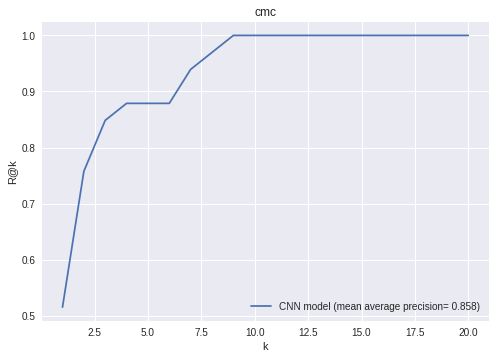

In [0]:
plt.figure(1)
plt.plot(xrange(1,21), ranks, label='CNN model (mean average precision= {:.3f})'.format(score))

plt.xlabel('k')
plt.ylabel('R@k')
plt.title('cmc')
plt.legend(loc='best')
plt.show()

# **`Exercises`**
1) Write your own implementation of recall, precision and f metrics. Test the results on the two introduced models (baseline and CNN) for multiclass classification problem on MNIST. Check that your results are the same as those computed by Sklearn. 

2) Write your own implementation of ROC curves and AUC. Afterwards, compare final results with those achieved with Sklearn methods.

3) Repeat the overall evaluation on CIFAR 100. If you are not satisfied with the performances, try to define your own CNN architecture.